# Title: Sampling Tool 
# Doc # : Gates-0000-1003
# Author: Charles Copley
# Date : 8 June 2017
# Revision: A

This includes an integration with the Rapid PRO API

In [2]:
#import libraries
import pandas as pd
import sqlalchemy 
import numpy as np
from bokeh.io import output_file, show
from bokeh.models import GeoJSONDataSource
from bokeh.plotting import figure
from bokeh.sampledata.sample_geojson import geojson
import psycopg2
import json
from bokeh.events import ButtonClick
from bokeh.models import Button
from random import random
from bokeh.layouts import column
from bokeh.models import Button
from bokeh.palettes import RdYlBu3
from bokeh.plotting import figure, curdoc
import os
from IPython.core.display import display, HTML
%matplotlib inline



In [2]:
json file requires
# rp group name
# rp start date

SyntaxError: invalid syntax (<ipython-input-2-991fcd8d05fd>, line 1)

In [428]:
#define the class for sampling
class SelectSample:
    #class to hold all the peripheral things required to sample the main DB
    #TBD 
    #--1. Unit Tests.
    #--2. Add capacity for joining new (as yet unseed) tables and information.
    #--3. Check the JSON file against the parent table name for column existence.
    
    def __init__(self,config_json_file):
        #test configuration variables
        self.config_json_file = config_json_file
        self.read_json_config()
        
        self.master_db_name = self.data['master_db_name']#this will be added as part of the
        self.database_port = self.data['database_port']
        self.database_server = self.data['database_server']
        self.user = self.data['user']
        self.pwd = self.data['pwd']
        #configuration script
        self.id_column = self.data['id_column'] # column that is used for the unique identifier
        self.investigation_id = int(self.data['investigation_id']) # Investigation number tag
        self.wave_id = int(self.data['wave_id']) # Investigation number tag
        self.parent_table_name = self.data['parent_table_name']
        self.filtered_table_name = self.data['filtered_table_name']
        self.all_samples_table_name = self.data['all_samples_table_name']
        #variable to hold whether the parent table has duplication or not.
        self.duplicates = True
        
        print('master_db_name: ',self.master_db_name)
        print('database_port: ',self.database_port)
        print('database_server: ',self.database_server)
        print('database_user: ',self.user)
        print('database_pwd: ',self.pwd)
        print('unique_field: ',self.id_column)
        print('investigation_id: ',self.investigation_id)
        print('all_samples_table: ',self.all_samples_table_name)
        print('population_filter: ',self.data['filter'])
        print('field_to_split: ', self.data['field_to_randomize'])
        print('values_to_use: ', list(self.data['samples_from_field'].keys()))
        print('number_to_select: ', list(self.data['samples_from_field'].values()))
         #name of the table that keeps all the previous samples
        #definition of the filter to be applied to the entire population
        filterJsonVals = self.data['filter']
        nFilters = len(filterJsonVals)
        self.population_filter = filterJsonVals[0]
        for i in range(1,nFilters):
            print(filterJsonVals[i])
            self.population_filter = self.population_filter + """ and """ + filterJsonVals[i]
            
        self.group_filter = self.data['field_to_randomize']
        self.group_values = list(self.data['samples_from_field'].keys())
        self.group_sample_number = list(self.data['samples_from_field'].values())
        #self.group_values = ['afr_ZA','eng_ZA','xho_ZA']
        #self.group_sample_number = [1000,200,250]
        self.temp_full_sample_table_name = "temp_wave_%d"%(int(self.wave_id)) 
    
    def check_duplicates(self):
        count_id_column = pd.read_sql("""
            select count(%s) 
            from %s 
            """%(self.id_column,self.parent_table_name),self.conn_db)
        count_distinct_id_column = pd.read_sql("""
            select count(distinct(%s)) 
            from %s 
            """%(self.id_column,self.parent_table_name),self.conn_db)
        if(count_id_column['count'].item() !=count_distinct_id_column['count'].item()):
            print('ID Column "%s" is not unique. \n Count %d Count distinct %d'%(self.id_column,count_id_column['count'],count_distinct_id_column['count']))
            self.duplicates = True
        elif(count_id_column['count'].item() == count_distinct_id_column['count'].item()):
            print('ID Column "%s" is unique. Yay! \n Count %d Count distinct %d'%(self.id_column,count_id_column['count'],count_distinct_id_column['count']))
            self.duplicates = False
        return(count_id_column,count_distinct_id_column)
    
    def read_json_config(self):
        with open(self.config_json_file) as data_file:
            self.data = json.load(data_file)
        return(self.data)
   
    def connect_to_db(self):
        self.conn_db=psycopg2.connect(dbname=self.master_db_name,user=self.user,password=self.pwd,
                port=self.database_port, host=self.database_server)
    
    def disconnect_from_db(self):
        self.conn_db.close()

    def read_test_data(self,file_to_read):
        test_data = pd.read_csv(file_to_read)
        return test_data
    
    def create_facility_augmented_database(self):
        self.parent_table_facility_code = "facility_code"
        self.clinic_table_facility_code = "facilitycode"
        self.clinic_facility_table = "clinic_facilities_with_gps"
        self.temp_augmented_table = "temp_table_for_augmented_facilities"
        conn = self.conn_db.cursor() #create cursor to execute the direct db commands over psycopg2

        sql_execution = """
                    CREATE TEMP TABLE %s as
                    (select * from %s as a
                    left join %s as b
                    on a.%s::integer = b.%s::integer);
                    """%(self.temp_augmented_table,self.parent_table_name,self.data["clinic_facility_table"], 
                        self.data["parent_table_facility_code"], self.data["clinic_table_facility_code"])
        conn.execute(sql_execution)
        conn.close()
    
    def create_filtered_database(self):
        conn = self.conn_db.cursor() #create cursor to execute the direct db commands over psycopg2
        sql_execution = """DROP TABLE IF EXISTS %s;"""%(self.filtered_table_name)
        conn.execute(sql_execution)
        sql_execution = """
        CREATE TEMP TABLE %s as (
                select *,
                %s as investigation_id, 
                %s as wave_id,
                '%s' as sample_config,
                '%s' as master_db_name,
                '%s' as parent_table_name
                from %s 
                where %s 
                );
        """%(self.filtered_table_name,
             self.investigation_id,
             self.wave_id,
             self.config_json_file,
             self.master_db_name,
             self.parent_table_name,
             self.parent_table_name,
             self.population_filter)
        conn.execute(sql_execution)
        conn.close()
        
    def create_full_sample_temp_table(self):
        conn = self.conn_db.cursor() #create cursor to execute the direct db commands
        temp_table_name = "group_0"
        sql_execution = """DROP TABLE IF EXISTS %s;"""%(self.temp_full_sample_table_name)
        conn.execute(sql_execution)
        sql_execution = """CREATE TEMP TABLE  %s (LIKE %s);"""%(self.temp_full_sample_table_name,temp_table_name)
        conn.execute(sql_execution)
        conn.close()
    
    #check if the table is required for the gates samples   
    def check_exists_investigations_gates_table(self):
        conn = self.conn_db.cursor() #create cursor to execute the direct db commands
        sql_query = """SELECT EXISTS 
        (SELECT 1 FROM   pg_tables 
            WHERE  schemaname = 'public' AND tablename = '%s');"""%(self.all_samples_table_name)
        conn.execute(sql_query)
        self.exists = conn.fetchall()[0][0]
        conn.close()
        return self.exists

    def create_all_investigations_gates_table_if_not_exist(self):
        """create the table to hold all the gates investigations if required"""  
        #create cursor to execute the direct db commands
        if (not self.check_exists_investigations_gates_table()):
            conn = self.conn_db.cursor()
            sql_execution = """CREATE TABLE %s as (select * from %s where 1=2) ;"""%(self.all_samples_table_name, self.temp_full_sample_table_name)
            conn.execute(sql_execution)
            self.conn_db.commit()
            conn.close()

    def append_group_sample(self,group_id):
        conn = self.conn_db.cursor() #create cursor to execute the direct db commands
        temp_full_sample_table_name = "temp_wave_%d"%(self.wave_id)
        temp_table_name = "group_"+str(group_id)
        sql_execution = """insert into %s select * from %s;"""%(self.temp_full_sample_table_name,temp_table_name)
        result = conn.execute(sql_execution)
        self.conn_db.commit()
        conn.close()
        return(result)
    
    def append_sample_to_all_investigation(self):
        conn = self.conn_db.cursor() #create cursor to execute the direct db commands
        sql_execution = """insert into %s select * from %s;"""%(self.all_samples_table_name,self.temp_full_sample_table_name)
        result = conn.execute(sql_execution)
        self.conn_db.commit()
        conn.close()
        return(result)
    
    def sample_groups(self):
        for group_id in range(0,len(self.group_values)):
            (a,b,df) = self.get_group_sample(group_id,
                                             self.investigation_id,
                                             self.wave_id,
                                             self.filtered_table_name,
                                             self.population_filter,
                                             self.group_filter,
                                             self.group_values[group_id],
                                             int(self.group_sample_number[group_id]))
            print('group_id: ',group_id,self.group_values[group_id])
        return(a,b,df)
    
    def append_groups(self):
        for i in range(0,len(self.group_values)):
            self.append_group_sample(i)
    
    def get_group_sample(self,group_id,investigation_id, wave_id,parent_table_name,
                         population_filter,group_filter,group_value,samples):
        #function to get the random samples from a given group
        conn = self.conn_db.cursor() #create cursor to execute the direct db commands over psycopg2
        temp_table_name = "group_"+str(group_id)
        sql_execution = """DROP TABLE IF EXISTS %s;"""%(temp_table_name)
        conn.execute(sql_execution)
        sql_execution = """
        CREATE TEMP TABLE %s as (
                select *,
                    random() as random,
                    %d as group_id
                from %s 
                where %s 
                and %s in ('%s') 
                order by random asc 
                limit %d);
        """%(temp_table_name,group_id,
             parent_table_name,population_filter,
             group_filter,group_value,
             samples)
        conn.execute(sql_execution)
        sql_execution_count = """
                select count(*)
                from %s
                where %s 
                and %s in ('%s');
                """%(parent_table_name,population_filter,group_filter,group_value)
        count = conn.execute(sql_execution_count)
        sample_count = pd.read_sql("""
                select count(*) 
                from %s;
                """%(temp_table_name),self.conn_db)
        full_count = pd.read_sql("""
                select count(*) 
                from %s 
                where %s 
                and %s in ('%s')
                """%(parent_table_name,population_filter,group_filter,group_value),self.conn_db)
        sample = pd.read_sql("""
                select * from %s;
                """%(temp_table_name),self.conn_db)
        conn.close()
        if sample_count['count'][0] < samples:
            # Create a new instance of an exception
            print('error')
            sample_error = ValueError("The requested sample from %s is too large" % (group_value))
            raise sample_error
        return(sample_count, full_count, sample)

    def get_final_wave_sample(self):
        """Return the samples that will be added for the final wave"""
        full_sample = pd.read_sql("""
            select * 
            from %s 
            """%(self.temp_full_sample_table_name),self.conn_db)
        return full_sample
    
    def get_augmented_sample(self):
        """Return the samples that have had clinic locations augmented using the facility code"""
        full_sample = pd.read_sql("""
            select * 
            from temp_table_for_augmented_facilities
            """,self.conn_db)
        return full_sample
    
    def get_all_investigations_sample(self):
        """Return the samples already stored in the Gates investigation table"""
        all_investigations_sample = pd.read_sql("""
            select * 
            from %s 
            """%(self.all_samples_table_name),self.conn_db)
        return all_investigations_sample
    
    
    def json_config_fields(self):
        """Return the configuration fields used in the JSON configuration file"""
        return(self.group_filter,self.group_values)
    
    def plot_histogram(self):
        self.get_final_wave_sample().groupby(self.data['field_to_randomize']).count()[self.data['id_column']].plot('bar')
    
    def return_pandas_sql_query(self,sql):
        #function to return a pandas dataframe of the temporary tables created above:
        #Typically these will be:
        #1. parent_table_name
        #2. gates_investigation_%d_filtered
        #3. all_gates_investigation_samples
        #4. temp_wave_%d
        #5. group_%d
        return(pd.read_sql(sql,self.conn_db))
    
    def clinic_locations_of_participants(self):
        sql_execution = """
                select a.*,b.lat,b.lon from
                temp_wave_1 as a
                join
                clinic_facilities_with_gps as b
                on a.%s::integer = b.%s::integer
                ;
        """%(self.parent_table_facility_code,self.clinic_table_facility_code)
        return(pd.read_sql(sql_execution,self.conn_db))
    
    def generate_folium_map(self):
        import folium
        locations = self.clinic_locations_of_participants().dropna()  
        m = folium.Map(location=[-30.92, 24.42],zoom_start=5,width=800, height=480)  
        marker_cluster = folium.MarkerCluster().add_to(m)
        for each in zip(locations.lat, locations.lon):
            folium.Marker(each).add_to(marker_cluster)
        m.save('base_map.html')
        return(m)
    
    def return_conn_db(self):
        return self.conn_db

In [430]:


#need to ensure the exploratory database is mapped to localhost
#ssh -p 22 -L6432:localhost:5432 charlescopley@prd-ndoh-analytics01.za.p16n.org
new_sample = SelectSample("test_instantiation.json") #create a new object of type SelectSample
new_sample.connect_to_db()  #connect to the DB
new_sample.check_duplicates()
#new_sample.create_facility_augmented_database()
new_sample.create_filtered_database()
new_sample.sample_groups()  #sample the groups that are part of the SelectSample definition
new_sample.create_full_sample_temp_table() #Create a temp table to hold all of the new samples
new_sample.append_groups()

#a = new_sample.get_augmented_sample()

#only needed the very first time
new_sample.create_all_investigations_gates_table_if_not_exist()
new_sample.append_sample_to_all_investigation()


master_db_name:  postgres
database_port:  6432
database_server:  localhost
database_user:  postgres
database_pwd:  postgres
unique_field:  id
investigation_id:  1
all_samples_table:  all_gates_investigations_samples
population_filter:  ["Province in ('ec Eastern Cape Province','kz KwaZulu-Natal Province','wc Western Cape Province','nc Northern Cape Province')", "facility_code not in ('Unavailable')", "edd between '2015-12-01' and '2016-06-01'"]
field_to_split:  lang
values_to_use:  ['afr_ZA', 'eng_ZA', 'xho_ZA']
number_to_select:  ['3', '7', '10']
facility_code not in ('Unavailable')
edd between '2015-12-01' and '2016-06-01'
ID Column "id" is not unique. 
 Count 100000 Count distinct 52425
group_id:  0 afr_ZA
group_id:  1 eng_ZA
group_id:  2 xho_ZA


100000

ID Column "id" is not unique. 
 Count 100000 Count distinct 52425


In [425]:
a=new_sample.return_pandas_sql_query("select * from temp_wave_1")

In [426]:
a

,registrant_id,id,data,details,edd,last_edd,msisdn_device,msisdn_registrant,msisdn_ecd_participants,facility_code,...,facilitycloseddate,lon,lat,investigation_id,wave_id,sample_config,master_db_name,parent_table_name,random,group_id
0,1c8dcd1f-8b48-4099-af56-5bf41514dbe3,1c8dcd1f-8b48-4099-af56-5bf41514dbe3,"{'edd': '2016-02-27', 'consent': False, 'facco...","{'source': 'clinic', 'consent': False, 'mom_do...",2016-02-27,None,27722399761,27722399761,27722399761,937833,...,None,19.0083,-32.5819,1,1,test_instantiation.json,postgres,test_seed_data_source,0.001094,0
1,748e82f8-d23d-4a28-81e9-c38f62c06b6a,748e82f8-d23d-4a28-81e9-c38f62c06b6a,"{'edd': '2016-01-12', 'consent': False, 'facco...","{'source': 'clinic', 'consent': False, 'mom_do...",2016-01-12,None,27789066540,27789066540,None,187642,...,None,22.2414,-33.5956,1,1,test_instantiation.json,postgres,test_seed_data_source,0.001411,0
2,f8710590-5a28-49e9-9e3d-d80ce418efa1,f8710590-5a28-49e9-9e3d-d80ce418efa1,"{'edd': '2016-03-16', 'consent': False, 'facco...","{'source': 'clinic', 'consent': False, 'mom_do...",2016-03-16,None,27764818599,27763976843,None,883615,...,None,19.4601,-33.6450,1,1,test_instantiation.json,postgres,test_seed_data_source,0.001612,0
3,e90b6ace-6dfa-4d1c-b608-59ee9259db65,e90b6ace-6dfa-4d1c-b608-59ee9259db65,"{'edd': '2016-01-11', 'consent': False, 'facco...","{'source': 'clinic', 'consent': False, 'mom_do...",2016-01-11,None,27835583747,27835583747,27835583747,473651,...,None,31.8325,-28.8600,1,1,test_instantiation.json,postgres,test_seed_data_source,0.000237,1
4,a028db6b-9ed6-4bdb-8ac9-d49eae9146a2,a028db6b-9ed6-4bdb-8ac9-d49eae9146a2,"{'edd': '2015-12-23', 'consent': False, 'facco...","{'source': 'clinic', 'consent': False, 'mom_do...",2015-12-23,None,27735429436,27781831204,27781831204,815242,...,None,25.5782,-33.7946,1,1,test_instantiation.json,postgres,test_seed_data_source,0.000275,1
5,f89ea36b-6976-4cf2-b177-de09970f6287,f89ea36b-6976-4cf2-b177-de09970f6287,"{'edd': '2016-03-04', 'consent': False, 'facco...","{'source': 'clinic', 'consent': False, 'mom_do...",2016-03-04,None,27782019601,27745456872,27745456872,262624,...,None,30.9218,-29.7081,1,1,test_instantiation.json,postgres,test_seed_data_source,0.000294,1
6,73aef04f-8002-4952-ad93-24758f0bc44e,73aef04f-8002-4952-ad93-24758f0bc44e,"{'edd': '2016-02-23', 'consent': False, 'facco...","{'source': 'clinic', 'consent': False, 'mom_do...",2016-02-23,None,27730888056,27730888056,27730888056,543133,...,None,30.8728,-29.9598,1,1,test_instantiation.json,postgres,test_seed_data_source,0.000329,1
7,31636aa0-89d9-4bfe-9025-fbadd0f8e1af,31636aa0-89d9-4bfe-9025-fbadd0f8e1af,"{'edd': '2016-01-23', 'consent': False, 'facco...","{'source': 'clinic', 'consent': False, 'mom_do...",2016-01-23,None,27765931452,27836208248,27836208248,528251,...,None,18.5264,-33.9946,1,1,test_instantiation.json,postgres,test_seed_data_source,0.000368,1
8,31b6ced7-20d5-454e-afc2-e706a1756ad6,31b6ced7-20d5-454e-afc2-e706a1756ad6,"{'edd': '2016-02-21', 'consent': False, 'facco...","{'source': 'clinic', 'consent': False, 'mom_do...",2016-02-21,None,27793863560,27793863560,27793863560,993160,...,None,30.6548,-29.8229,1,1,test_instantiation.json,postgres,test_seed_data_source,0.000399,1
9,c0cad7bc-03ab-49b2-97e4-043a549323dd,c0cad7bc-03ab-49b2-97e4-043a549323dd,"{'edd': '2016-02-10', 'consent': False, 'facco...","{'source': 'personal', 'consent': False, 'mom_...",2016-02-10,None,27719204068,27719204068,None,828833,...,None,30.4346,-29.5556,1,1,test_instantiation.json,postgres,test_seed_data_source,0.000487,1


limit_output extension: Maximum message size of 10000 exceeded with 14532 characters

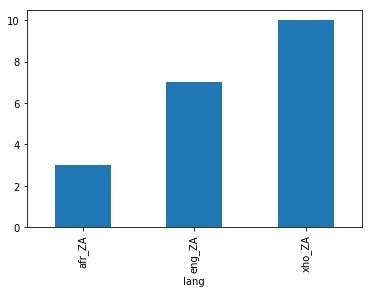

In [362]:
#produce a few plots of the data

a = new_sample.json_config_fields()
final_wave = new_sample.plot_histogram()


In [345]:
#generate map of the participant locations
display(new_sample.generate_folium_map())

DatabaseError: Execution failed on sql '
                select a.*,b.lat,b.lon from
                temp_wave_1 as a
                join
                clinic_facilities_with_gps as b
                on a."Facility.code"::integer = b.facilitycode::integer
                ;
        ': column a.Facility.code does not exist
LINE 6:                 on a."Facility.code"::integer = b.facilityco...
                           ^
HINT:  Perhaps you meant to reference the column "a.facility_code" or the column "a.facilitycode".


In [61]:
#final data set for eyeballing
samples_to_upload = new_sample.get_final_wave_sample()
samples_to_upload.head(5)

MSISDN Facility.code         EDD      ID.Number Language  \
0  27840510784        412642  2016-04-09  8512100150081   afr_ZA   
1  27634419675        915542  2016-03-05    Unavailable   afr_ZA   
2  27824344153        216015  2016-02-21    Unavailable   afr_ZA   
3  27789828134        707342  2016-02-25    Unavailable   eng_ZA   
4  27711437697        767015  2016-03-19  8204020934089   eng_ZA   

                 province  investigation_id  wave_id  \
0   Eastern Cape Province                 1        1   
1  Northern Cape Province                 1        1   
2   Western Cape Province                 1        1   
3  KwaZulu-Natal Province                 1        1   
4   Eastern Cape Province                 1        1   

                 sample_config master_db_name  \
0  investigation_1_wave_1.json       postgres   
1  investigation_1_wave_1.json       postgres   
2  investigation_1_wave_1.json       postgres   
3  investigation_1_wave_1.json       postgres   
4  invest

limit_output extension: Maximum message size of 1000 exceeded with 2653 characters

In [62]:
a = new_sample.get_all_investigations_sample()

In [421]:
new_sample.disconnect_from_db()


In [66]:
a.count()

MSISDN               80
Facility.code        80
EDD                  80
ID.Number            80
Language             80
province             80
investigation_id     80
wave_id              80
sample_config        80
master_db_name       80
parent_table_name    80
random               80
group_id             80
dtype: int64

In [102]:
#and the rapipro API
from temba_client.v2 import TembaClient
#read in all the data
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 1000})



In [256]:
class pandasRapidPro:
    def __init__(self):
        #set up the connection to the rapidPRO DB
        api_key = '6dd5ab0dfe4836fe70429c1eb9a94e1513017fd8' #get this from the rapidpro website
        self.client = TembaClient('rapidpro.qa.mhealthengagementlab.org', api_key)

    def read_contact_urns(self):
        contacts  = self.client.get_contacts()
        df = pd.DataFrame(columns=["urn"])
        for a in iter(contacts.all()):
            df = df.append({"urn" :a.urns[0]}, ignore_index=True)
        return(df)
    
    def read_contact_fields(self):
        import pandas as pd
        #get the contact fields from the rapidpro data
        contacts  = self.client.get_contacts()
        field = []
        urns = []
        for contact in iter(contacts.all()):
            urn_dict = {"urns" : contact.urns[0]}
            name_d
            fields_dict = contact.fields
            fields_dict.update(urn_dict)
            field.append(fields_dict)
            #urns.append({"urns" : contact.urns[0]})
        df = pd.DataFrame(field)
        return(df)


In [267]:
        contacts  = client.get_contacts()
        cc = contacts.first()


In [282]:
    cc.groups[0].name

'Recruitment: investigation_1_wave_1'

In [259]:
nrpd = pandasRapidPro()


In [260]:
b = nrpd.read_contact_urns()
b.columns


Index(['urn'], dtype='object')

In [266]:
c= nrpd.read_contact_fields()
c['urns']

0     tel:+27837271075
1     tel:+27781280879
2     tel:+27787451061
3     tel:+27781727070
4     tel:+27717563814
5     tel:+27833679790
6     tel:+27782290513
7     tel:+27768067026
8     tel:+27715821820
9     tel:+27730232180
10    tel:+27826896395
11    tel:+27834789794
12    tel:+27846327644
13    tel:+27732899710
14    tel:+27733382442
15    tel:+27604699301
16    tel:+27849947135
17    tel:+27797502284
18    tel:+27736091646
19    tel:+27730753787
20    tel:+27844301160
21    tel:+27713519728
Name: urns, dtype: object

In [126]:
#extracting the urn from the rapid pro db over API


,urn
0,tel:+27837271075
1,tel:+27781280879
2,tel:+27787451061
3,tel:+27781727070
4,tel:+27717563814
5,tel:+27833679790
6,tel:+27782290513
7,tel:+27768067026
8,tel:+27715821820


limit_output extension: Maximum message size of 1000 exceeded with 1903 characters

In [96]:
for a in iter(contacts.all()):
    print(a.urns)

['tel:+27837271075']
['tel:+27781280879']
['tel:+27787451061']
['tel:+27781727070']
['tel:+27717563814']
['tel:+27833679790']
['tel:+27782290513']
['tel:+27768067026']
['tel:+27715821820']
['tel:+27730232180']
['tel:+27826896395']
['tel:+27834789794']
['tel:+27846327644']
['tel:+27732899710']
['tel:+27733382442']
['tel:+27604699301']
['tel:+27849947135']
['tel:+27797502284']
['tel:+27736091646']
['tel:+27730753787']
['tel:+27844301160']
['tel:+27713519728']


In [ ]:
group_name = "Investigation %s Wave %s"%(json_config['investigation_id'], json_config['wave_id'])
client.create_group(group_name)

In [ ]:
group_object = client.get_groups(name=group_name)
group_object.first()

In [ ]:
contacts_list = ('tel:+'+samples_to_upload.MSISDN[1:10]).tolist() #create a list of the MSISDN
contacts_list

In [ ]:
samples_to_upload.Language.str.replace('_ZA','')[1:10]
client.create_field("investigation-id", "numeric")
client.create_field("wave-id", "numeric")

In [ ]:
a = iter(samples_to_upload)
group_names = ['Recruitment: investigation_1_wave_1']
rp_start_date = '15-07-2017 00:00'
for index,row in samples_to_upload.iterrows():
    contact_urn = ('tel:+'+row['MSISDN'])
    contact_language = row['Language'].replace('_ZA','')
    group_vals = group_name
    custom_field_dict = {"seed_language":row['Language'],"investigation_id": int(json_config['investigation_id']),
                         "wave_id" : int(json_config['wave_id']),"rp_start_date" : rp_start_date  }
    print(index,contact_urn,contact_language,custom_field_dict)
    #client.delete_contact(contact_urn)
    client.create_contact(language=contact_language, urns=[contact_urn],
                          fields = custom_field_dict, groups = group_names)

In [ ]:
group_object = client.get_groups(name=group_name)
group_object.first().name
client.bulk_add_contacts(contacts_list, group_object.first())